### Use case of this project 
- Steel Plate is a steel sheet material that is robust and is used in strengthening constructional buildings . It is made by burdening multiple steel layers into one.
- Steel plates are usually used to support and strengthen the foundation of buildings and defend mass units of weight such like bridges, we can also say that steel plates provide a foundation of construction.
- Aim: The aim of this prediction is to determine the type of surface defects in steel plates, There are 7 types of possible defects that the model predicts which are Pastry (0), Z_Scratch(1), K_Scatch(2), Stain(3), Dirtiness(4), Bumps(5), and Other_Faults(6).

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [149]:
df = pd.read_csv('steel_faults.csv')

# Print the shape of the dataset
print(df.shape)

print(f"Number of Rows in the Dataset: {df.shape[0]}")
print(f"Number of Columns in the Dataset: {df.shape[1]}")
# Print the column names
print(df.columns)


(1941, 28)
Number of Rows in the Dataset: 1941
Number of Columns in the Dataset: 28
Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Faults'],
      dtype='object')


Let us first look at the first five rows of the dataset to get a better understanding of the dataset

In [150]:
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,0


**Faults** is the target variable that we are trying to predict. Let us plot it and see its distribution

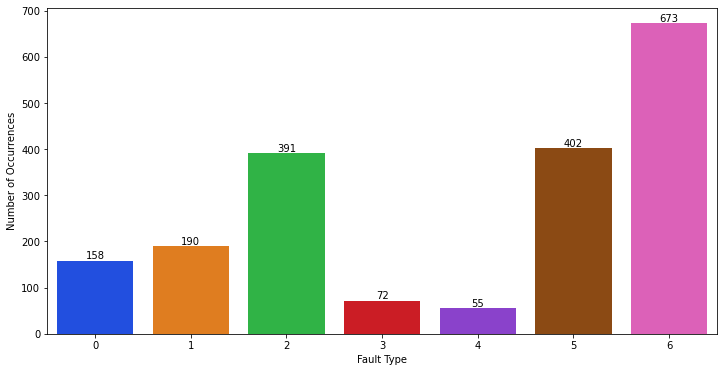

In [151]:
plt.figure(figsize=(12,6))
targetValueCount = df["Faults"].value_counts()
ax = sns.barplot(x=targetValueCount.index, y=targetValueCount, palette='bright')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Fault Type')
plt.ylabel('Number of Occurrences')
plt.show()


As evident from the plot above we have **six unique types of fault**. **Fault Type 6 is the most common** whereas **Fault Type 4 is least common**. 

Let us also visualize the percentage distribution of the Faults

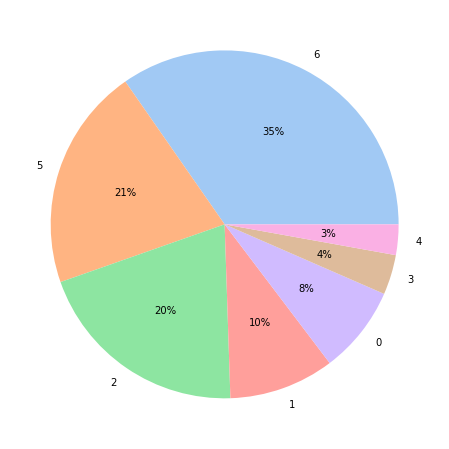

In [152]:
plt.rcParams["figure.figsize"] = (15,8)
palette_colors = sns.color_palette('pastel')
ax = plt.pie(targetValueCount, labels=targetValueCount.index, colors=palette_colors, autopct='%.0f%%')
plt.show()


In [153]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

All 28 of our columns are numeric only. So we donot need to convert their types.

Since we are working on a Supervised task and we have a Target Variable whose value we are trying to predict by training a model, it is recommended to filter out the most important columns. These most important columns are the ones that affect the values of the target variable **Faults** the most. 

There are multiple methods to determine importance. Once such method is Correlation. Below we will draw a correlation heatmap and on the basis of it will calculate the most important columns. 

Note: Since we want to determine the important columns, we will discard the sign of correlation. i.e., we will make negative correlations as postive as we care about only magnitude

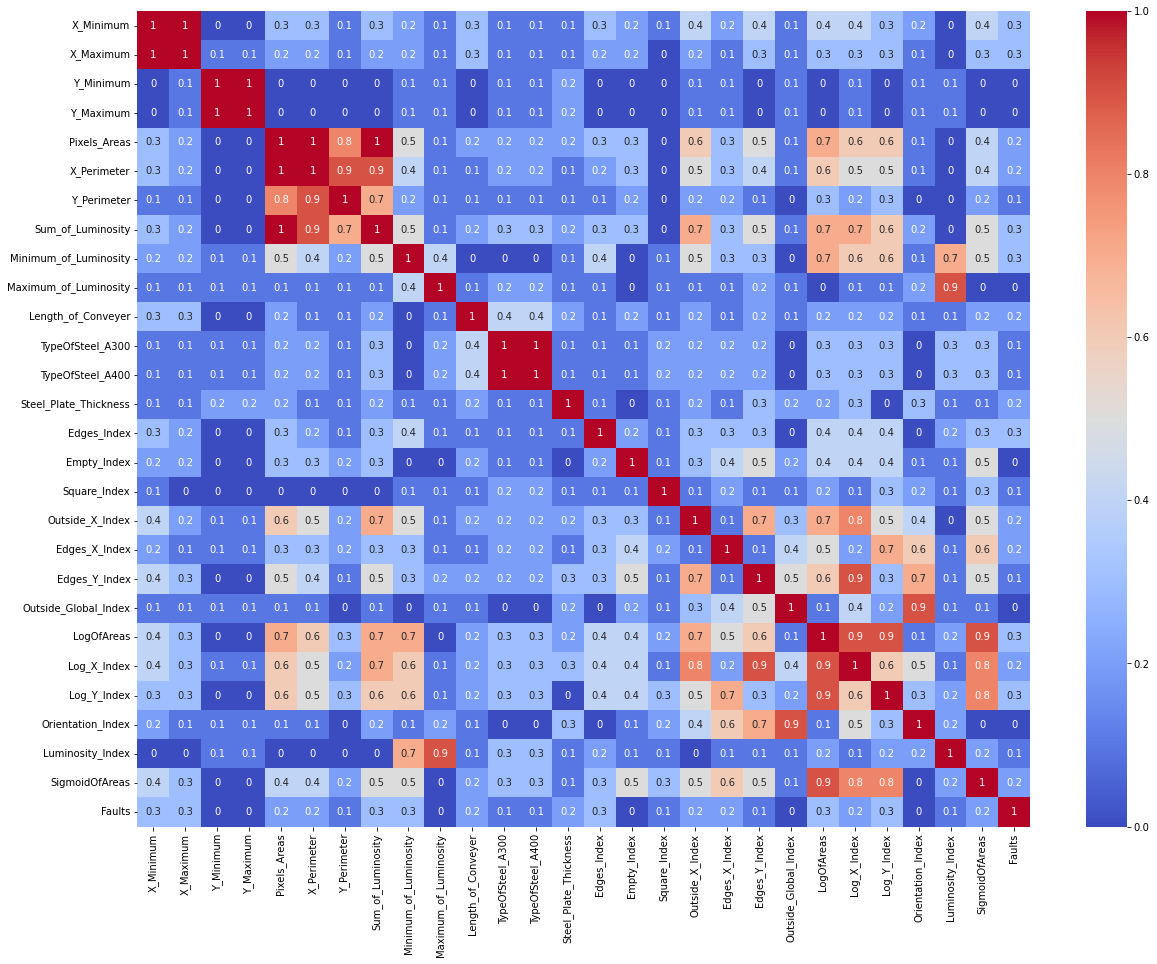

In [154]:
plt.figure(figsize=(20, 15))
corr = abs(round(df.corr(), 1))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()


Above is a pretty big plot showing correlation of every column with each other. Let us refine it to show only the correlation corresponding to the Target column Faults since that is what we require.

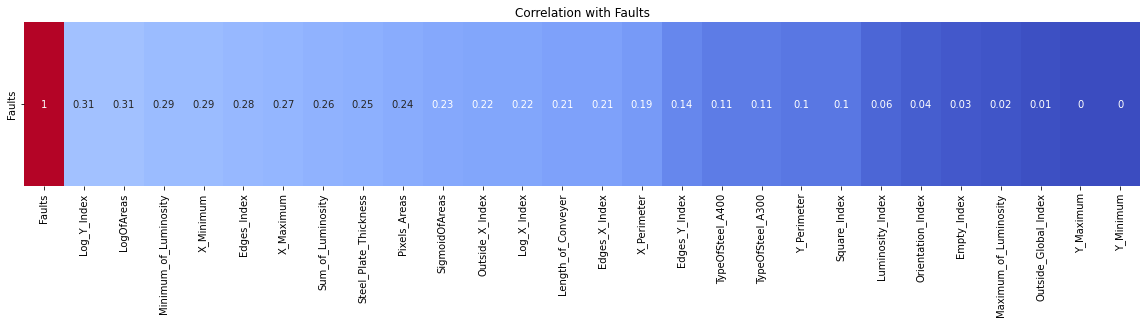

In [155]:
plt.rcParams["figure.figsize"] = (20, 3)
faultsCorrDf = abs(round(df.corr()[['Faults']], 2)).sort_values(by=["Faults"], ascending=False)
sns.heatmap(faultsCorrDf.transpose(),cmap = 'coolwarm', annot=True, cbar=False)
plt.title("Correlation with Faults")
plt.show()

Above plot shows the amount of correlation each columns has with **Faults** column. **Log_Y_index** has the highest correlation whereas **Y_Minumun** and **Y_Maximun** have the lowest.

The Columns/Feature which have very low correlation with our target variable generally have very less affect on the predictive model. So we will discard the columns having correlation less that 0.1. 

Columns to drop are

In [156]:
# calculate correlation coefficients with "Faults" and select columns with correlation coefficient less than 0.1
corr_with_faults = abs(round(df.corr()['Faults'], 2))
columnsToDrop = corr_with_faults[corr_with_faults < 0.1].index.values
columnsToDrop

array(['Y_Minimum', 'Y_Maximum', 'Maximum_of_Luminosity', 'Empty_Index',
       'Outside_Global_Index', 'Orientation_Index', 'Luminosity_Index'],
      dtype=object)

There are total of 7 columns that are to be dropped

In [157]:
mod_df = df.drop(columnsToDrop, axis=1)
print(mod_df.shape)

(1941, 21)


In [158]:
mod_df.head()

,X_Minimum,X_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,...,Edges_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,LogOfAreas,Log_X_Index,Log_Y_Index,SigmoidOfAreas,Faults
0,42,50,267,17,44,24220,76,1687,1,0,...,0.0498,0.1818,0.0047,0.4706,1.0000,2.4265,0.9031,1.6435,0.5822,0
1,645,651,108,10,30,11397,84,1687,1,0,...,0.7647,0.2069,0.0036,0.6000,0.9667,2.0334,0.7782,1.4624,0.2984,0
2,829,835,71,8,19,7972,99,1623,1,0,...,0.9710,0.3333,0.0037,0.7500,0.9474,1.8513,0.7782,1.2553,0.2150,0
3,853,860,176,13,45,18996,99,1353,0,1,...,0.7287,0.1556,0.0052,0.5385,1.0000,2.2455,0.8451,1.6532,0.5212,0
4,1289,1306,2409,60,260,246930,37,1353,0,1,...,0.0695,0.0662,0.0126,0.2833,0.9885,3.3818,1.2305,2.4099,1.0000,0


Now let us describe our dataset. Following table describes the dataset in brief by giving standard statistical information

In [159]:
mod_df.describe()

,X_Minimum,X_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,...,Edges_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,LogOfAreas,Log_X_Index,Log_Y_Index,SigmoidOfAreas,Faults
count,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1.941000e+03,1941.000000,1941.000000,1941.000000,1941.000000,...,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,571.136012,617.964451,1893.878413,111.855229,82.965997,2.063121e+05,84.548686,1459.160227,0.400309,0.599691,...,0.331715,0.570767,0.033361,0.610529,0.813472,2.492388,1.335686,1.403271,0.585420,3.841319
std,520.690671,497.627410,5168.459560,301.209187,426.482879,5.122936e+05,32.134276,144.577823,0.490087,0.490087,...,0.299712,0.271058,0.058961,0.243277,0.234274,0.788930,0.481612,0.454345,0.339452,2.144175
min,0.000000,4.000000,2.000000,2.000000,1.000000,2.500000e+02,0.000000,1227.000000,0.000000,0.000000,...,0.000000,0.008300,0.001500,0.014400,0.048400,0.301000,0.301000,0.000000,0.119000,0.000000
25%,51.000000,192.000000,84.000000,15.000000,13.000000,9.522000e+03,63.000000,1358.000000,0.000000,0.000000,...,0.060400,0.361300,0.006600,0.411800,0.596800,1.924300,1.000000,1.079200,0.248200,2.000000
50%,435.000000,467.000000,174.000000,26.000000,25.000000,1.920200e+04,90.000000,1364.000000,0.000000,1.000000,...,0.227300,0.555600,0.010100,0.636400,0.947400,2.240600,1.176100,1.322200,0.506300,5.000000
75%,1053.000000,1072.000000,822.000000,84.000000,83.000000,8.301100e+04,106.000000,1650.000000,1.000000,1.000000,...,0.573800,0.818200,0.023500,0.800000,1.000000,2.914900,1.518500,1.732400,0.999800,6.000000
max,1705.000000,1713.000000,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,1794.000000,1.000000,1.000000,...,0.995200,1.000000,0.875900,1.000000,1.000000,5.183700,3.074100,4.258700,1.000000,6.000000


One problem that we can clearly see from the above table is that the range of the individual columns is very different from each other.

For example, **Pixels_Areas** and **Minimum_of_Luminosity**. 

**Pixels_Areas** column has maximun value at **152655** whereas the maximum value of **Minimum_of_Luminosity** is **203** which is a big difference. 

Similarly, **Pixels_Areas** column has mean value at **1893.87** whereas the mean value of **Minimum_of_Luminosity** is **84.54** which is again a big difference. 

One way to deal with this range issue is that we scale whole of data into some particular predefined range. We will be using MinMaxScaler from Sklearn library to scale our datase

In [160]:
# We will be removing the Faults column as its our target column and we dont
# need to scale it
mod_df.drop(columns=["Faults"], inplace=True)
scaler = MinMaxScaler()
scaledArr = scaler.fit_transform(mod_df)
print(mod_df.shape, scaledArr.shape)

(1941, 20) (1941, 20)


In [161]:
# Our Dataframe will be converted into a numpy array with values like this:
scaledArr

array([[2.46334311e-02, 2.69163253e-02, 1.73596326e-03, ...,
        2.17121633e-01, 3.85915890e-01, 5.25766175e-01],
       [3.78299120e-01, 3.78583967e-01, 6.94385305e-04, ...,
        1.72081786e-01, 3.43391176e-01, 2.03632236e-01],
       [4.86217009e-01, 4.86249269e-01, 4.52005529e-04, ...,
        1.72081786e-01, 2.94761312e-01, 1.08967083e-01],
       ...,
       [8.50439883e-02, 9.94733762e-02, 1.89973338e-03, ...,
        4.18809275e-01, 2.76164088e-01, 6.68444949e-01],
       [8.03519062e-02, 9.71328262e-02, 2.73168559e-03, ...,
        4.39039342e-01, 3.50200765e-01, 9.90805902e-01],
       [7.39589443e-01, 7.47220597e-01, 6.61631281e-04, ...,
        3.60607263e-01, 2.82738864e-01, 4.66061294e-01]])

We Will first fetch our taget variable in a seperate variable **target** 

In [162]:
target = df["Faults"]

We will also convert our target variable into categorical form




In [163]:
y_cat = pd.Categorical(target)
y_cat

[0, 0, 0, 0, 0, ..., 6, 6, 6, 6, 6]
Length: 1941
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]

We will now split our data into training and testing set. We will be using train_test_split function from sklearn

In [164]:
X_train, X_test, y_train, y_test = train_test_split(scaledArr, y_cat, test_size=0.15, random_state=1)

In [165]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1649, 20), (292, 20), (1649,), (292,))

### Model Training 

#### LogisticRegression 

Logistic Regression Classifier:
F1 score: 0.6659848772202235
Accuracy Score: 0.68
Confusion Matrix:


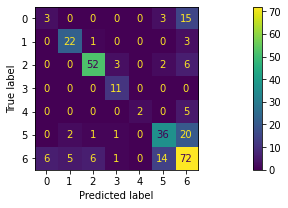

In [166]:
# Train the LogisticRegression Model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the model's performance using accuracy score and confusion matrix
acc_log_reg = accuracy_score(y_test, y_pred_log_reg)
conf_mat = confusion_matrix(y_test, y_pred_log_reg)

# evaluate the performance of the model
print("Logistic Regression Classifier:")
f1 = f1_score(y_test, y_pred_log_reg, average='weighted')
print("F1 score:", f1)
print(f"Accuracy Score: {acc_log_reg:.2f}")
print("Confusion Matrix:")
classes = np.unique(y_cat)
ConfusionMatrixDisplay(conf_mat, display_labels=classes).plot();


#### Decision Tree

Decision Tree Classifier:
Accuracy: 0.54
F1 Score: 0.41
Confusion Matrix:


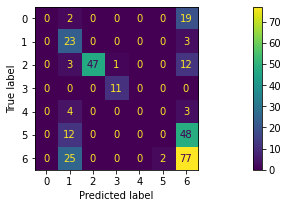

In [173]:
# Create the model with max_depth=3
dt = DecisionTreeClassifier(max_depth=3)

# Fit the model on the training data
dt.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

# evaluate the performance of the model
print("Decision Tree Classifier:")
print(f"Accuracy: {acc_dt:.2f}")
f1_dt = f1_score(y_test, y_pred_dt, average='macro')
print(f"F1 Score: {f1_dt:.2f}")
print("Confusion Matrix:")
cm_dt = confusion_matrix(y_test, y_pred_dt)
classes = np.unique(y_cat)
ConfusionMatrixDisplay(cm_dt, display_labels=classes).plot();

#### Random Forest

Random Forest Classifier:
Accuracy: 1 3
F1 Score: 0.758
Confusion Matrix:


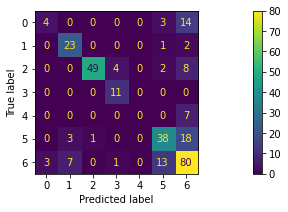

In [174]:
# create a Random Forest Classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training data
rf.fit(X_train, y_train)

# predict the classes of the test data
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
# evaluate the performance of the model
print("Random Forest Classifier:")
print("Accuracy:", round(acc_rf), 3)
print("F1 Score:", round(f1_score(y_test, y_pred_rf, average='weighted'), 3))
print("Confusion Matrix:")
conf_mt = confusion_matrix(y_test, y_pred_rf)
classes = np.unique(y_cat)
ConfusionMatrixDisplay(conf_mat, display_labels=classes).plot();

#### SVM

SVM Classifier:
Accuracy: 1 3
F1 Score: 0.686
Confusion Matrix:
Confusion Matrix:


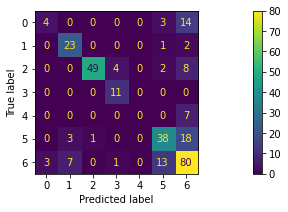

In [169]:
# Create a SVM classifier with a linear kernel
svm = SVC(kernel='linear')

# Fit the model to the training data
svm.fit(X_train, y_train)

# Predict the classes of the test data
y_pred_svm = svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)

# Evaluate the performance of the model
print("SVM Classifier:")
print("Accuracy:", round(acc_svm), 3)
print("F1 Score:", round(f1_score(y_test, y_pred_svm, average='weighted'), 3))
print("Confusion Matrix:")
conf_mat = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
classes = np.unique(y_cat)
ConfusionMatrixDisplay(conf_mat, display_labels=classes).plot();

#### XGBoost

XGBoost Classifier:
Accuracy: 1 3
F1 Score: 0.776
Confusion Matrix:


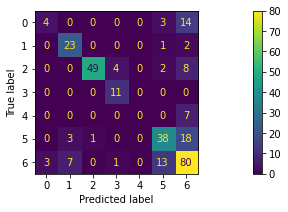

In [170]:
# create an XGBoost Classifier
xgb = XGBClassifier(random_state=42)

# fit the model to the training data
xgb.fit(X_train, y_train)

# predict the classes of the test data
y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

# evaluate the performance of the model
print("XGBoost Classifier:")
print("Accuracy:", round(acc_xgb), 3)
print("F1 Score:", round(f1_score(y_test, y_pred_xgb, average='weighted'), 3))
print("Confusion Matrix:")
conf_mt = confusion_matrix(y_test, y_pred_xgb)
classes = np.unique(y_cat)
ConfusionMatrixDisplay(conf_mat, display_labels=classes).plot();



#### Naive Bayes

Naive Bayes Classifier:
Accuracy: 1 3
F1 Score: 0.575
Confusion Matrix:


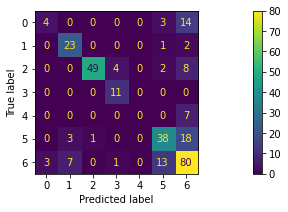

In [171]:
# create a Naive Bayes classifier
nb = GaussianNB()

# fit the model to the training data
nb.fit(X_train, y_train)

# predict the classes of the test data
y_pred_nb = nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

# evaluate the performance of the model
print("Naive Bayes Classifier:")
print("Accuracy:", round(acc_nb), 3)
print("F1 Score:", round(f1_score(y_test, y_pred_nb, average='weighted'), 3))
print("Confusion Matrix:")
conf_mt = confusion_matrix(y_test, y_pred_nb)
classes = np.unique(y_cat)
ConfusionMatrixDisplay(conf_mat, display_labels=classes).plot();


### Comparing the performance of the model

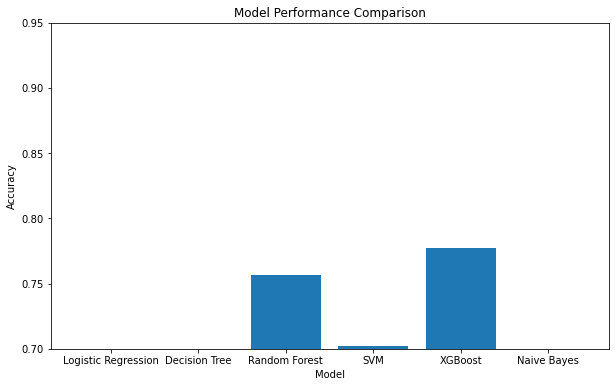

In [172]:
# create a list of models and their respective accuracies
models = ["Logistic Regression", "Decision Tree", "Random Forest", "SVM", "XGBoost","Naive Bayes"]
accuracies = [acc_log_reg, acc_dt, acc_rf, acc_svm, acc_xgb, acc_nb]

# plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)
plt.ylim(0.7, 0.95)
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()


So according to the bar plot we can see that **XGBoost** performed better than any other model.